# Volume Data in FLOW
*Temporal Distribution Plots*

Note: 
    * In all plots, segments refer to unique directional centreline segments

In [49]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import preprocess
from pg import DB
import configparser
from tabulate import tabulate

## Function - Histogram

In [20]:
def PHistogram(title, xlabel, ylabel, df, col, color):
    ''' This function creates a new plot and plot histogram based on parameters given.
        INPUT: title: plot title
                xlabel, ylabel: axes labels
                df: dataframe to be plotted
                col: column name in the df to be plotted
                color: color of bars'''
    maxValue = max(df[col])    
    fig, ax = plt.subplots(figsize = [maxValue/2,5])

    bins = [i+0.5 for i in list(range(maxValue))]
    n,bins,patches=plt.hist(df[col],bins=bins,color=color)
    
    plt.xlim([0.5,maxValue+0.5])
    plt.ylim([0,14000])
    ax.get_xaxis().set_visible(False)
    for count,x in zip (n,bins[:-1]):
        ax.annotate(str(int(count)), xy=(x+0.5,0), xycoords=('data', 'axes fraction'),
            xytext=(0, -25), textcoords='offset points', va='top', ha='center')
        ax.annotate(str(int(x+0.5)), xy=(x+0.5,0), xycoords=('data', 'axes fraction'),
            xytext=(0, -10), textcoords='offset points', va='top', ha='center')
    plt.subplots_adjust(bottom=0.15)
    plt.title(title)
    ax.annotate(xlabel, xy=(maxValue+0.5,0), xycoords=('data', 'axes fraction'), 
        xytext=(0, -10), textcoords='offset points', va='top', ha='left')
    ax.set_ylabel(ylabel)

## DB Setup and Data Input

In [14]:
CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
db = DB(dbname=dbset['database'],host=dbset['host'],user=dbset['user'],passwd=dbset['password'])

In [24]:
data = pd.read_csv('coverage_summary.csv')
data = data.dropna()
data['year'] = data['year'].astype(int)
data['month'] = data['month'].astype(int)
data['season'] = data.apply(preprocess.makeseasons,axis=1)
centrelines = pd.DataFrame(db.query('SELECT centreline_id, feature_code_desc FROM prj_volume.centreline').getresult(), columns = ['centreline_id','feature_code_desc'])
data = data.merge(centrelines, on='centreline_id', how='inner')

## 1. Number of Segments vs. Number of Years Counted

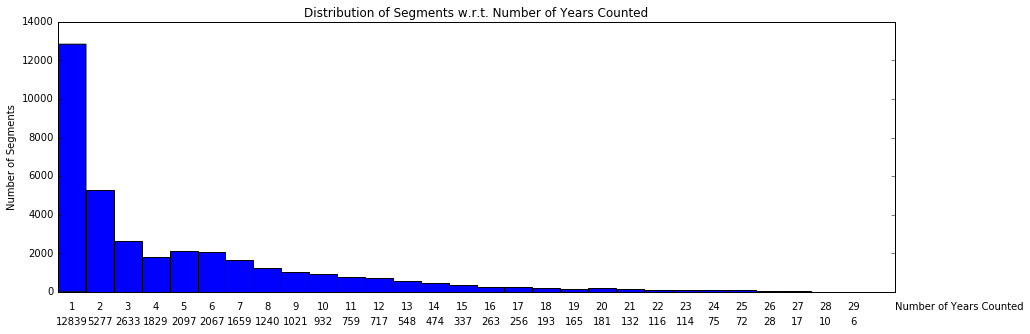

In [21]:
data1 = pd.DataFrame(data.groupby(['centreline_id','dir_bin']).year.nunique())
data1.reset_index(inplace=True)

PHistogram('Distribution of Segments w.r.t. Number of Years Counted','Number of Years Counted','Number of Segments',data1,'year','blue')

## 2. Number of Segments vs. Number of Years (ATR only)

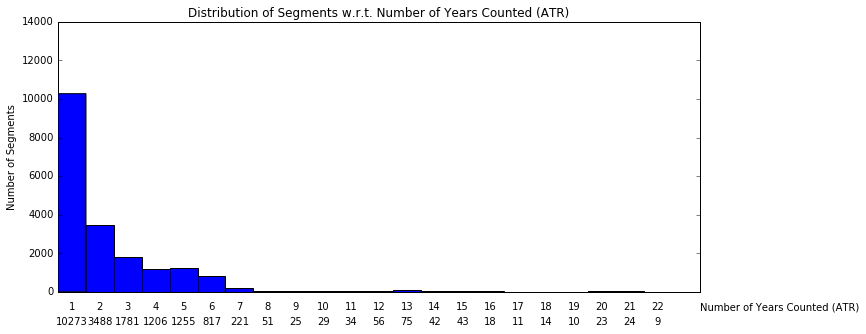

In [22]:
data1 = data[data['count_type']==1]    
data1 = pd.DataFrame(data1.groupby(['centreline_id','dir_bin']).year.nunique())
data1.reset_index(inplace=True)

PHistogram('Distribution of Segments w.r.t. Number of Years Counted (ATR)','Number of Years Counted (ATR)','Number of Segments',data2,'year','blue')

## 3. Distribution of Segments in Different Seasons

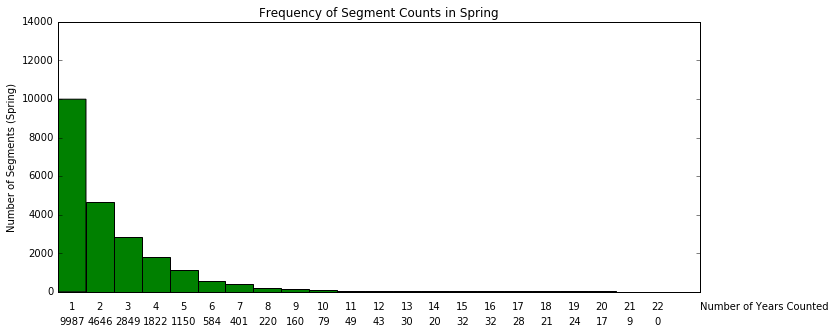

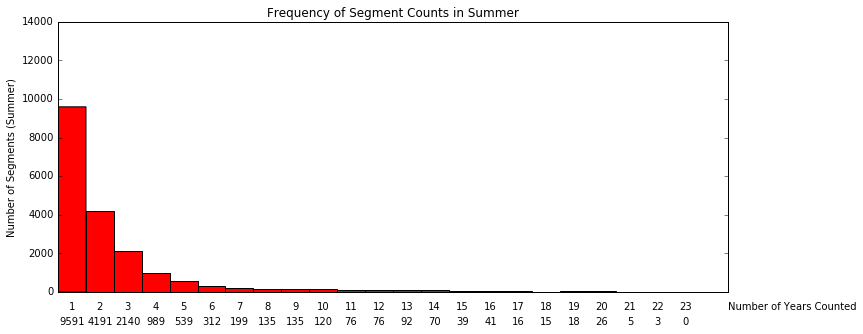

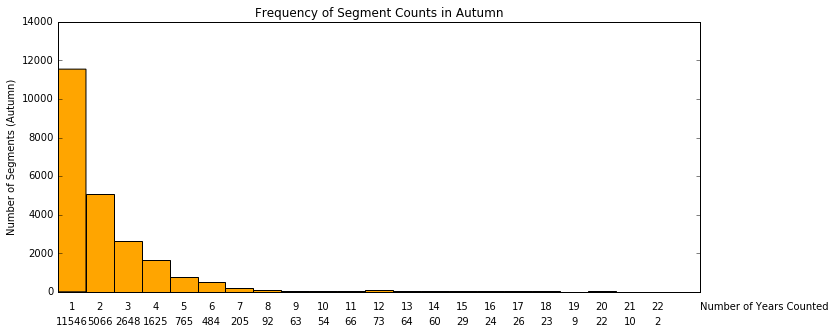

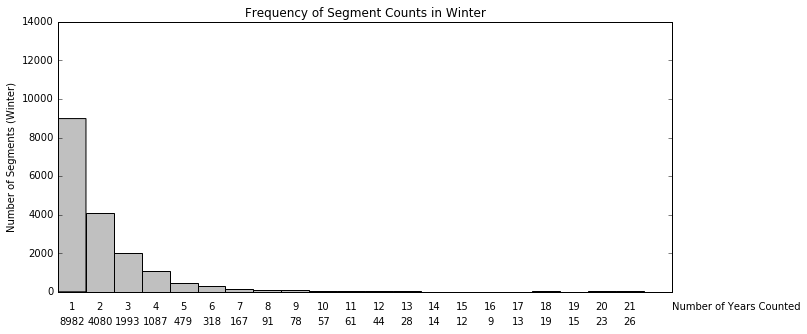

In [27]:
data1 = pd.DataFrame(data.groupby(['centreline_id','dir_bin','season']).year.nunique())
data1.reset_index(inplace=True)

PHistogram('Frequency of Segment Counts in Spring','Number of Years Counted','Number of Segments (Spring)',data3[data3['season']=='Spring'],'year','green')
PHistogram('Frequency of Segment Counts in Summer','Number of Years Counted','Number of Segments (Summer)',data3[data3['season']=='Summer'],'year','red')
PHistogram('Frequency of Segment Counts in Autumn','Number of Years Counted','Number of Segments (Autumn)',data3[data3['season']=='Autumn'],'year','orange')
PHistogram('Frequency of Segment Counts in Winter','Number of Years Counted','Number of Segments (Winter)',data3[data3['season']=='Winter'],'year','silver')


## 4. Number of Count Days in Each Year

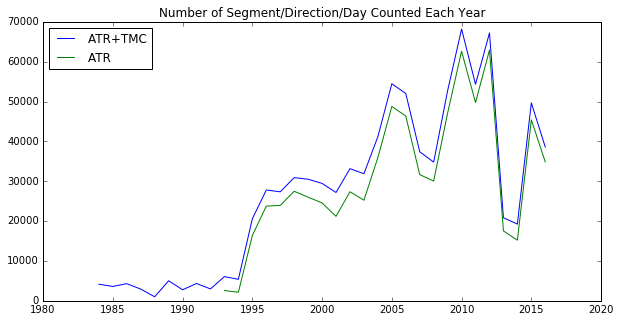

In [28]:
fig, ax = plt.subplots(figsize = [10,5])
data1 = data.groupby(['year'],as_index=False).count()
plt.plot(data1['year'],data1['centreline_id'],label="ATR+TMC")
data1 = data[data['count_type'] == 1].groupby(['year'],as_index=False).count()
plt.plot(data1['year'],data1['centreline_id'],label="ATR")
plt.title('Number of Segment/Direction/Day Counted Each Year')
plt.legend(loc=2)

## 5. Number of Count Days Separated by Day of Week Each Year

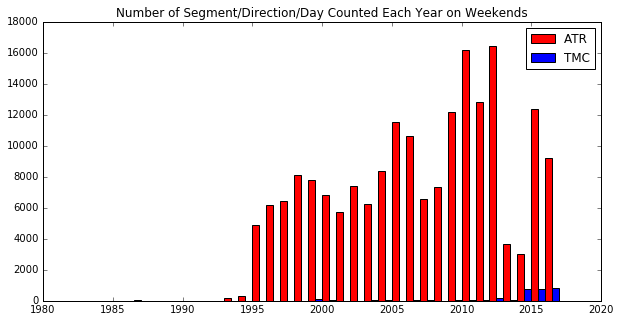

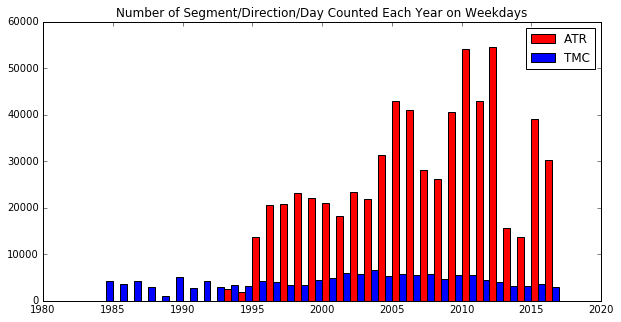

In [31]:
fig, ax = plt.subplots(figsize = [10,5])
data1 = data[(data['dow'] == 0) | (data['dow'] == 6)]
data1 = data1.groupby(['year','count_type'],as_index=False).count()
ax.bar(data1[data1['count_type']==1]['year'],data1[data1['count_type']==1]['centreline_id'],0.5,color='r',label='ATR')
ax.bar(data1[data1['count_type']==2]['year']+0.5,data1[data1['count_type']==2]['centreline_id'],0.5,color='b',label='TMC')
plt.title('Number of Segment/Direction/Day Counted Each Year on Weekends')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize = [10,5])
data1 = data[(data['dow']<0) | (data['dow']<6)]
data1 = data1.groupby(['year','count_type'],as_index=False).count()
ax.bar(data1[data5['count_type']==1]['year'],data1[data1['count_type']==1]['centreline_id'],0.5,color='r',label='ATR')
ax.bar(data1[data5['count_type']==2]['year']+0.5,data1[data1['count_type']==2]['centreline_id'],0.5,color='b',label='TMC')
plt.title('Number of Segment/Direction/Day Counted Each Year on Weekdays')
plt.legend()
plt.show()

## 6. Number of Segments By Month

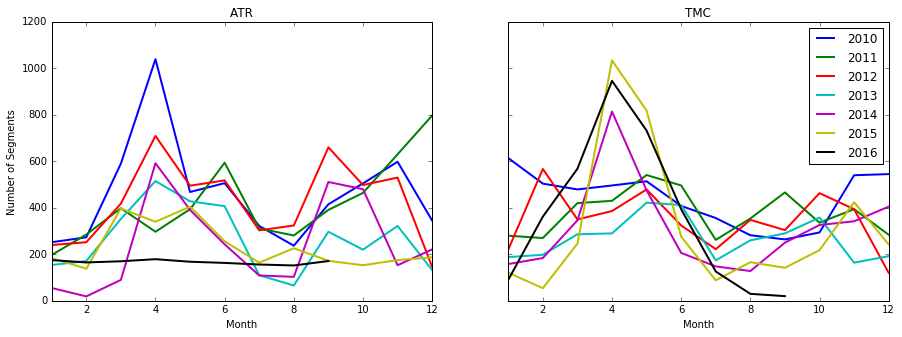

In [103]:
data1 = data[data['year']>2009]
data1 = data1[['year','month','count_type','dir_bin','centreline_id']].drop_duplicates()
data1['year'] = data1['year'].astype(int)
fig,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(15,5))
ax1.set_xlim(1,12)
ax2.set_xlim(1,12)
for (year,count_type),group in data1.groupby(['year','count_type']):
    g1 = group.groupby(['month'],as_index=False).size()
    if count_type == 1:
        ax1.plot(g1.index,g1.values,label=int(year),linewidth=2)
    else:
        ax2.plot(g1.index,g1.values,label=int(year),linewidth=2)
plt.legend()
plt.title('Number of Segments by Month')
ax1.set_title('ATR')
ax2.set_title('TMC')
ax1.set_xlabel('Month')
ax2.set_xlabel('Month')
ax1.set_ylabel('Number of Segments')
plt.show()

## 7. Number of Segments Counted by Road Type

In [102]:
# Time in scope
data1 = data[data['year']>2000]
data1 = pd.DataFrame(data1.groupby(['year','feature_code_desc']).centreline_id.nunique())
data1.reset_index(inplace=True)
# Set road types in scope
combine = list(data1['feature_code_desc'].unique())
combine.remove('Local')
combine.remove('Major Arterial')
combine.remove('Major Arterial Ramp')
combine.remove('Minor Arterial')
combine.remove('Collector')
combine.remove('Collector Ramp')
combine.remove('Expressway')
combine.remove('Expressway Ramp')
combine.remove('Laneway')

data1['year'] = data1['year'].astype(int)

# Construct Pivot Table
data1 = pd.pivot_table(data1,index=['year'],columns=['feature_code_desc'],values='centreline_id')

# Combine minor road Types
data1['Others'] = data1[combine].sum(axis=1)
data1.drop(combine, axis=1, inplace=True)
data1 = data1.fillna(0)
data1[data1.columns] = data1[data1.columns].astype(int)

data1

feature_code_desc,Collector,Collector Ramp,Expressway,Expressway Ramp,Laneway,Local,Major Arterial,Major Arterial Ramp,Minor Arterial,Others
year,,,,,,,,,,
2001,563,2,54,89,37,948,1493,9,564,26
2002,591,0,43,59,29,943,1707,6,592,27
2003,690,2,40,65,10,1061,1938,37,785,46
2004,698,0,51,85,19,1000,1574,11,850,37
2005,688,0,73,119,33,924,1557,11,846,39
2006,715,0,60,76,33,1240,1661,18,609,37
2007,966,5,57,99,17,902,1491,30,586,54
2008,547,1,60,75,18,564,1410,12,620,43
2009,787,2,76,67,20,731,1482,5,805,41


In [104]:
db.close()